In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Jan 23 21:24:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   35C    P8    38W / 250W |      1MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 50%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 75

# Name is the output file name





folder = '23Jan_DDplus_KDE_B_loss_Ba_iter4B_floatAll_75epochs_1em5_4xwill'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 48 ## batch_size = 24 ---> 4763MiB / 12066MiB on Titan V
# How fast to learn
learning_rate = 1e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kdeB_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

## finished at training cost = 1.46, validation cost = 1.50
##d_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
d_folder = '23Jan_DDplus_KDE_B_loss_Ba_iter3B_floatAll_50epochs_1em5_4xwill'
d_name = d_folder
suffix = 'final'
dict_name = 'ML/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)



output =  ML/23Jan_DDplus_KDE_B_loss_Ba_iter4B_floatAll_75epochs_1em5_4xwill
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   2

<All keys matched successfully>

In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:

## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                    '/share/lazy/will/data/June30_2020_80k_2.h5',
                                    '/share/lazy/will/data/June30_2020_80k_3.h5',
                                    '/share/lazy/will/data/June30_2020_80k_4.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                          device=device,
##                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,

## For iter12, change slice(18000,None) to slice(10000,None)
## First, we'll see if this changes the validation cost significantly
##  Second, we will see if this reduces the validation cost fluctuations
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
##                            device=device,
                            slice = slice(10000,None)
                           )


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  0.00045611936
majorAxis[iTrk][1][0] =  -4.8292455e-05
majorAxis[iTrk][2][0] =  0.090019904
minorAxis_1[iTrk][0][0] =  -1.8602173
minorAxis_1[iTrk][1][0] =  -17.569641
minorAxis_1[iTrk][2][0] =  4.7891795e-08
minorAxis_2[iTrk][0][0] =  -17.569414
minorAxis_2[iTrk][1][0] =  1.8601931
minorAxis_2[iTrk][2][0] =  0.0900199
  
majorAxis[iTrk][0][0] =  0.002360258
majorAxis[iTrk][1][0] =  -0.007426616
majorAxis[iTrk][2][

len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 41.04 s
outer loop X.shape =  (20000, 9, 600)
Constructing 10000 event dataset took 0.0523 s
x_t.shape =  torch.Size([10000, 9, 600])
x_t.shape[0] =  10000
x_t.shape[1] =  9
x_t.shape =  torch.Size([10000, 9, 600])


<IPython.core.display.Javascript object>


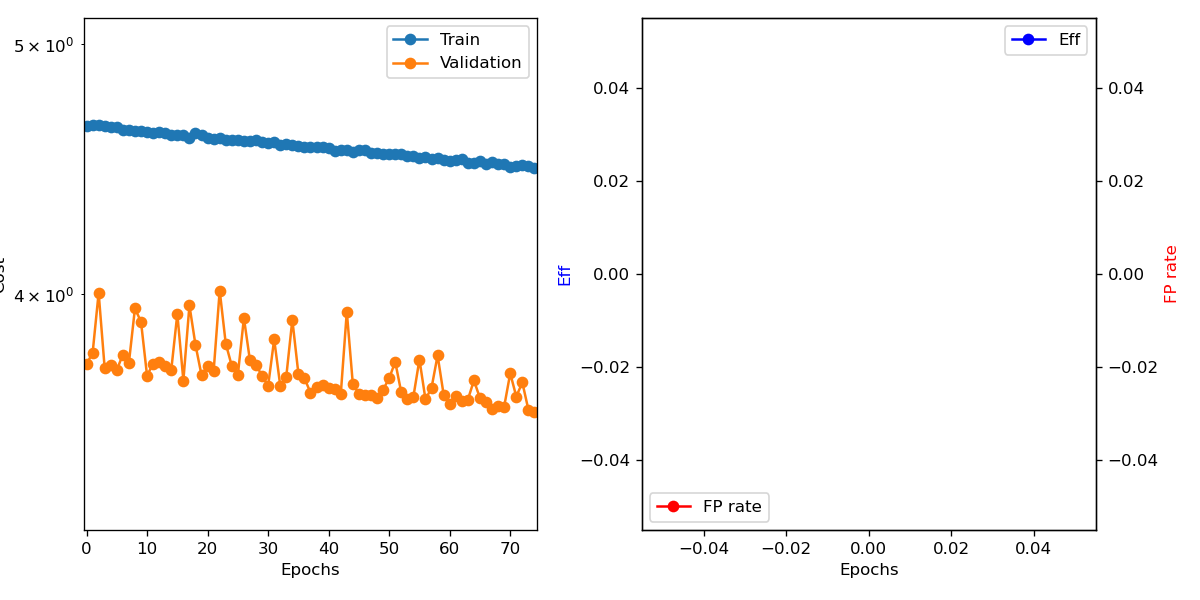

In [16]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [17]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 6667, val = 209


Number of batches: train = 6667, val = 209


Epoch 0: train=4.64799, val=3.75876, took 591.13 s


Epoch 1: train=4.65081, val=3.79419, took 599.11 s


Epoch 2: train=4.64997, val=4.00419, took 547.06 s


Epoch 3: train=4.64439, val=3.74321, took 544.93 s


Epoch 4: train=4.64229, val=3.75526, took 544.85 s


Epoch 5: train=4.64201, val=3.73834, took 546.1 s


Epoch 6: train=4.63037, val=3.7893, took 544.12 s


Epoch 7: train=4.63136, val=3.76229, took 544.84 s


Epoch 8: train=4.62604, val=3.94896, took 545.16 s


Epoch 9: train=4.62509, val=3.90206, took 545.92 s


Epoch 10: train=4.62351, val=3.71905, took 549.08 s


Epoch 11: train=4.6157, val=3.75922, took 548.41 s


Epoch 12: train=4.62096, val=3.76485, took 548.24 s


Epoch 13: train=4.6173, val=3.75192, took 548.92 s


Epoch 14: train=4.60899, val=3.73865, took 549.05 s


Epoch 15: train=4.60868, val=3.92983, took 544.49 s


Epoch 16: train=4.61033, val=3.7029, took 543.93 s


Epoch 17: train=4.59813, val=3.95954, took 547.79 s


Epoch 18: train=4.61777, val=3.82241, took 546.42 s


Epoch 19: train=4.60834, val=3.72072, took 545.62 s


Epoch 20: train=4.59755, val=3.752, took 545.52 s


Epoch 21: train=4.5921, val=3.73443, took 547.64 s


Epoch 22: train=4.59718, val=4.01243, took 550.9 s


Epoch 23: train=4.59059, val=3.82692, took 552.94 s


Epoch 24: train=4.58894, val=3.75161, took 550.12 s


Epoch 25: train=4.58919, val=3.72155, took 549.02 s


Epoch 26: train=4.58324, val=3.91539, took 549.48 s


Epoch 27: train=4.58567, val=3.76981, took 552.66 s


Epoch 28: train=4.58894, val=3.75452, took 550.14 s


Epoch 29: train=4.57914, val=3.71903, took 549.67 s


Epoch 30: train=4.57697, val=3.68515, took 551.99 s


Epoch 31: train=4.58022, val=3.84152, took 556.19 s


Epoch 32: train=4.56943, val=3.68652, took 556.42 s


Epoch 33: train=4.57037, val=3.71612, took 558.75 s


Epoch 34: train=4.56947, val=3.90914, took 553.38 s


Epoch 35: train=4.56252, val=3.7259, took 556.97 s


Epoch 36: train=4.55873, val=3.71103, took 550.21 s


Epoch 37: train=4.5602, val=3.66303, took 550.36 s


Epoch 38: train=4.55897, val=3.68265, took 549.71 s


Epoch 39: train=4.56131, val=3.6898, took 551.48 s


Epoch 40: train=4.55534, val=3.67847, took 594.55 s


Epoch 41: train=4.54589, val=3.67381, took 599.62 s


Epoch 42: train=4.54705, val=3.65732, took 552.45 s


Epoch 43: train=4.5471, val=3.93711, took 557.28 s


Epoch 44: train=4.53904, val=3.69059, took 552.29 s


Epoch 45: train=4.54605, val=3.65923, took 557.15 s


Epoch 46: train=4.54638, val=3.65502, took 610.67 s


Epoch 47: train=4.53494, val=3.65626, took 599.62 s


Epoch 48: train=4.53497, val=3.64744, took 553.37 s


Epoch 49: train=4.53058, val=3.67289, took 549.66 s


Epoch 50: train=4.53192, val=3.71085, took 551.75 s


Epoch 51: train=4.52978, val=3.7652, took 550.65 s


Epoch 52: train=4.53115, val=3.66385, took 551.72 s


Epoch 53: train=4.52279, val=3.6425, took 551.41 s


Epoch 54: train=4.52555, val=3.64994, took 551.05 s


Epoch 55: train=4.51396, val=3.77307, took 550.82 s


Epoch 56: train=4.51772, val=3.64095, took 551.43 s


Epoch 57: train=4.51168, val=3.67925, took 549.73 s


Epoch 58: train=4.51423, val=3.78677, took 552.24 s


Epoch 59: train=4.50866, val=3.65648, took 548.96 s


Epoch 60: train=4.50349, val=3.62695, took 551.22 s


Epoch 61: train=4.50738, val=3.65279, took 552.56 s


Epoch 62: train=4.51084, val=3.63634, took 550.21 s


Epoch 63: train=4.49685, val=3.6404, took 551.07 s


Epoch 64: train=4.49719, val=3.70344, took 554.02 s


Epoch 65: train=4.50343, val=3.64528, took 550.32 s


Epoch 66: train=4.49158, val=3.6325, took 549.27 s


Epoch 67: train=4.49774, val=3.61075, took 549.66 s


Epoch 68: train=4.49122, val=3.62129, took 554.92 s


Epoch 69: train=4.49051, val=3.61816, took 556.75 s


Epoch 70: train=4.479, val=3.72682, took 549.19 s


Epoch 71: train=4.48275, val=3.65055, took 551.31 s


Epoch 72: train=4.48727, val=3.69655, took 549.97 s


Epoch 73: train=4.48492, val=3.60808, took 543.24 s


Epoch 74: train=4.47734, val=3.60097, took 542.98 s



Go ahead and save the final model (even though it was also saved above):

In [18]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [19]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


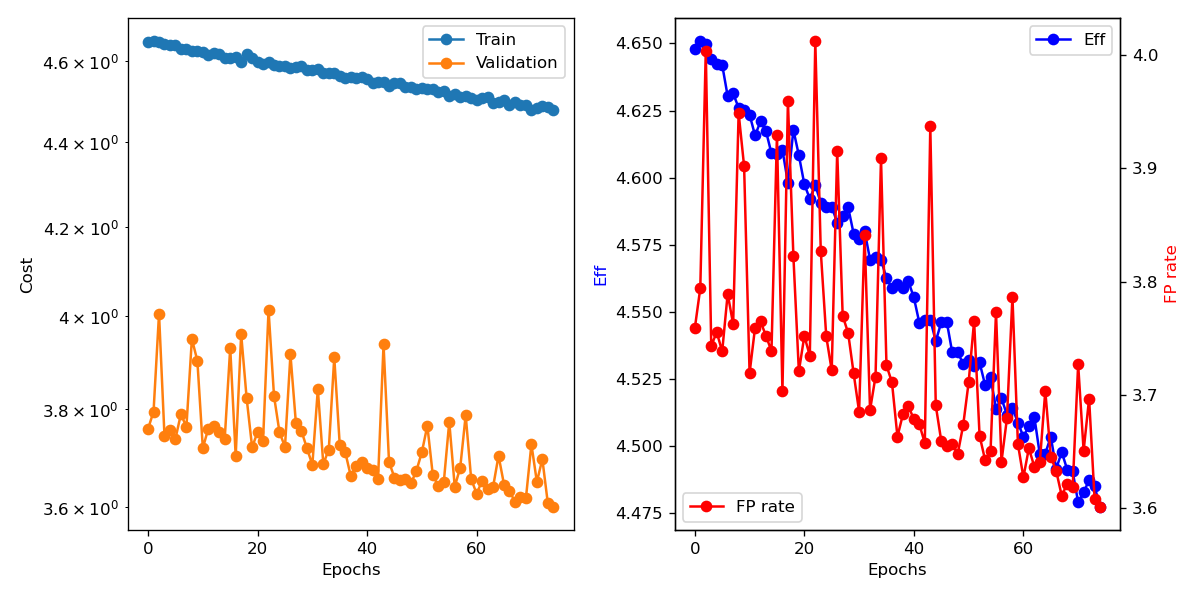

In [20]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [1]:
##quit()